In [1]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv('./stayzilla_com-travel_sample.csv')
df = df[['additional_info', 'amenities', 'city', 'description', 'image_count', 'latitude', 'longitude', 'occupancy', 'property_id', 'property_name', 'property_type', 'room_price', 'room_types', 'service_value']]

In [10]:
df = df.assign(
    room_price=df.room_price.map(
        lambda v: float(v[:v.find("per")]) if not pd.isnull(v) else np.nan
    ),
    acceptance_rate=df.additional_info.map(
        lambda v: v.split("|")[0].split(":")[-1].split(" ")[0] if not pd.isnull(v) else np.nan
    ),
    response_time=df.additional_info.map(
        lambda v: v.split("|")[-1].split(":")[-1] if not pd.isnull(v) else np.nan
    ),
    adult_occupancy=df.occupancy.map(
        lambda v: float(v.split(" ")[0]) if not pd.isnull(v) else np.nan
    ),
    child_occupancy=df.occupancy.map(
        lambda v: float(v.split(" ")[-2]) if not pd.isnull(v) else np.nan
    ),
    service_value=df.service_value.map(
        lambda v: np.nan if pd.isnull(v) else v if v in ['Not Verified', 'Verified'] else np.nan
    ),
    amenity_split=df.amenities.fillna("").map(
        lambda f: [am.strip() for am in f.split("|")]
    )
)

In [11]:
import itertools
top_amenities = pd.Series(
    list(itertools.chain(*(df.amenities.fillna("").map(lambda f: [am.strip() for am in f.split("|")])
                            .values.tolist())))).value_counts().head(13).index.values
top_amenities = [am for am in top_amenities if am != ""] 

for amenity in top_amenities:
    df[amenity] = df.amenity_split.map(lambda l: amenity in l)

In [15]:
df.columns

Index(['city', 'description', 'image_count', 'latitude', 'longitude',
       'property_id', 'property_name', 'property_type', 'room_price',
       'room_types', 'service_value', 'acceptance_rate', 'response_time',
       'adult_occupancy', 'child_occupancy', 'AC', 'Newspaper', 'Parking',
       'WiFi', 'Card Payment', 'Elevator', 'Pickup & Drop', 'Free Breakfast',
       'Veg Only', 'Bar', 'Laundry', 'Car Parking'],
      dtype='object')

In [101]:
# We can see that the Car Parking is duplicated with Parking
df['Parking'] = (df['Car Parking'] | df['Parking'])


,city,description,image_count,latitude,longitude,property_id,property_name,property_type,room_price,room_types,...,Parking,WiFi,Card Payment,Elevator,Pickup & Drop,Free Breakfast,Veg Only,Bar,Laundry,Car Parking
0,Kalimpong,Sangsey Valley Resort is Located at the wonder...,3.0,27.087429,88.531357,67368,Sangsey Valley Resort,Resort,3167.0,3 Bedded Room,...,False,False,False,False,False,False,False,False,False,False


In [13]:
df.drop(['amenity_split', 'amenities', 'additional_info', 'occupancy', 'Car Parking'], axis=1, inplace=True)

In [118]:
df.to_csv('./stayzilla_rough_cleaned.csv', index=False)

In [46]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix
import folium
import matplotlib.pyplot as plt

In [111]:
# df = pd.read_csv('./stayzilla_rough_cleaned.csv')

# Make a copy for analysis
df_work = df.copy()
# df_work.dropna(subset=['room_price'], inplace=True)

In [164]:
# # Select the input features
# df_amenity = df_work[['AC', 'Newspaper', 'Parking','WiFi', 'Card Payment', 'Elevator', 'Pickup & Drop', 'Free Breakfast', 'Veg Only', 'Bar', 'Laundry']]

# # Encode the features
# le = preprocessing.LabelEncoder()
# X = df_amenity.apply(lambda x : le.fit_transform(x))
X = df_work[['latitude', 'longitude','room_price', 'Newspaper', 'Parking','service_value',
       'Card Payment', 'Elevator', 'Pickup & Drop', 'Veg Only', 'Bar', 'Laundry', 'adult_occupancy',
       'child_occupancy', 'num_amenities', 'zones', 'descr_len', 'deluxe', 'num_simhotel', 'wifi', 'ac', 'breakfast',
       'response_label', 'Apartment', 'Homestay', 'Hotel', 'House', 'Lodge', 'Resort', 'Spa', 'Villa']]

In [115]:
# Fit into classifier to determine the best number of clusters
def km(X, n):
    model = KMeans(n_clusters=n).fit(X)
    # According to the documentation, the inertia calculate the SSE between the point and the centroid
    # We can use it to evaluate our model
    iner = model.inertia_
    pred = model.predict(X)
    return iner, pred

labels = []
inertia = []
list_k = list(range(4, 15))
for n in list_k:
    a, b = km(X, n)
    inertia.append(a)
    labels.append(b)



```
df_work['room_price'] = (df_work['room_price'] - df_work['room_price'].min()) / (df_work['room_price'].max() - df_work['room_price'].min())
X_norm = pd.concat([X, df_work['room_price']], axis=1)
X_norm.head()
```

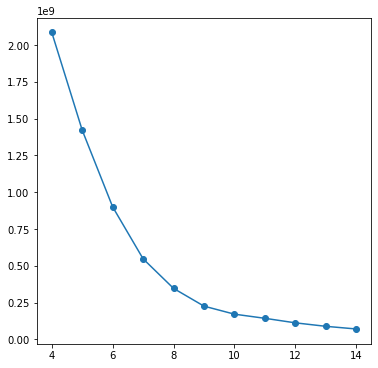

In [116]:
# Using sse to find the best number of clustering
plt.figure(figsize=(6, 6))
plt.plot(list_k, inertia, '-o')

In [117]:
# The line drops significantly from 4 to 8, 
# since we don't want too much clustering to confuse stakeholders, 
# we will choose 6 in our project
df_temp = pd.DataFrame(labels[2], columns=['class'])

# Combine the cluster results with other information for visualization
df_map = df_work[['longitude', 'latitude', 'room_price', 'property_name']]
df_map = pd.concat([df_map, df_temp], axis=1)

In [118]:
# Plot each property on the map, and use different color to indicate the clustering
m = folium.Map(
    location=[21.15, 79.09],
    zoom_start=4
)

colors = ['red', 'brown', 'green', 'blue', 'purple', 'orange']
for i in range(0, 7):
    df_map[df_map['class'] == i].apply(lambda ll: folium.Circle(radius=ll.room_price,
                                              location=[ll.latitude, ll.longitude],
                                              stroke = True,
                                              color=colors[i],
                                              opacity=0.3,
                                              popup=ll.property_name).add_to(m), axis='columns')

m.save("cluster.html")

In [119]:
# The map above is good to see the price, but difficult to see exact location
# The code below will plot another map with fix radius
m = folium.Map(
    location=[21.15, 79.09],
    zoom_start=4
)

for i in range(0, 7):
    df_map[df_map['class'] == i].apply(lambda ll: folium.Circle(radius=200,
                                              location=[ll.latitude, ll.longitude],
                                              stroke = True,
                                              fill=True,
                                              color=colors[i],
                                              popup=ll.property_name).add_to(m), axis='columns')

m.save("cluster_clear.html")

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>],
       [<AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>],
       [<AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>]], dtype=object)

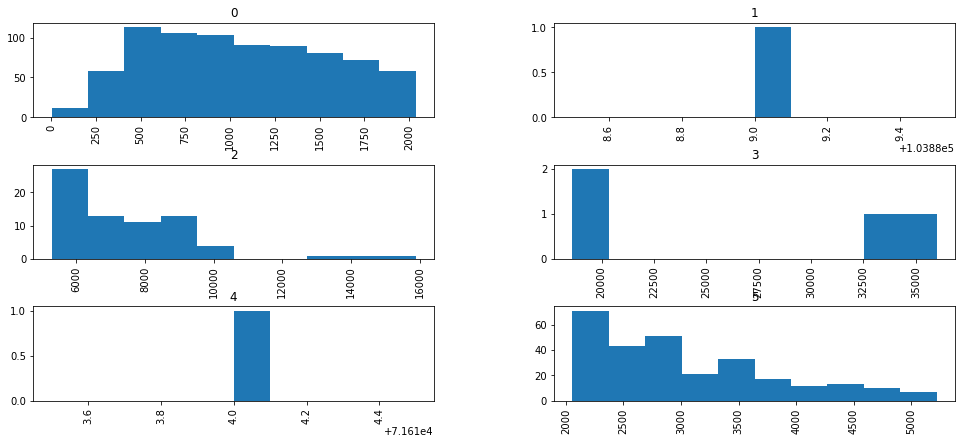

In [120]:
df_map['room_price'].hist(by=df_map['class'], figsize=(16, 7))

In [30]:
df1 = pd.read_csv('./stayzilla_rough_cleaned.csv')
df2 = pd.read_csv('./stayzillaCleanFeatures.csv')

In [31]:
df = df1.merge(df2, how = 'left', on='property_id')

In [32]:
df = df[['city_x', 'description_x', 'image_count_x', 'latitude', 'longitude',
       'property_id', 'property_name', 'property_type', 'room_price_x', 'Newspaper', 'Parking',
       'Card Payment', 'Elevator', 'Pickup & Drop', 
       'Veg Only', 'Bar', 'Laundry', 'adult_occupancy_y',
       'child_occupancy_y', 'num_amenities', 'zones', 'descr_len', 'deluxe',
       'num_simhotel', 'wifi', 'ac', 'breakfast', 'service_value_y',
       'acceptance_rate_y', 'response_label', 'Apartment', 'Homestay', 'Hotel',
       'House', 'Lodge', 'Resort', 'Spa', 'Villa']]

In [33]:
df.rename(columns={'city_x':'city', 'description_x':'description', 'image_count_x':'image_count',
                'room_price_x':'room_price', 'adult_occupancy_y':'adult_occupancy', 'child_occupancy_y':'child_occupancy', 
                'service_value_y':'service_value', 'acceptance_rate_y':'acceptance_rate'}, inplace=True)

In [69]:
df.dtypes

city                object
description         object
image_count        float64
latitude           float64
longitude          float64
property_id          int64
property_name       object
property_type       object
room_price         float64
Newspaper            int64
Parking              int64
Card Payment         int64
Elevator             int64
Pickup & Drop        int64
Veg Only             int64
Bar                  int64
Laundry              int64
adult_occupancy      int64
child_occupancy      int64
num_amenities        int64
zones                int64
descr_len            int64
deluxe               int64
num_simhotel         int64
wifi                 int64
ac                   int64
breakfast            int64
service_value        int64
acceptance_rate      int64
response_label       int64
Apartment            int64
Homestay             int64
Hotel                int64
House                int64
Lodge                int64
Resort               int64
Spa                  int64
V

In [61]:
le = preprocessing.LabelEncoder()
df.iloc[:, 9:17] = df.iloc[:, 9:17].apply(lambda x : le.fit_transform(x))

In [65]:
df.dropna(subset=['room_price'], inplace=True)

In [68]:
df.iloc[:, 17:] = df.iloc[:, 17:].astype(int)

In [70]:
df.to_csv('./stayzilla_combined_clean.csv', index=False)

In [ ]:
def normalize(df, col):
    df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

def knn(X, y, n):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)

    a = accuracy_score(y_test, y_pred)
    b = f1_score(y_test, y_pred.round(), zero_division=1)
    # print(confusion_matrix(y_test, y_pred))
    return a, b

In [93]:
def multiple_knn(m, n):
    s1 = 0
    s2 = 0
    for i in range(0, m):
        acc, f = knn(X, y, n)
        s1 = s1+acc
        s2 = s2+f
    return s1/m, s2/m

In [110]:
X = df[['latitude', 'longitude','room_price', 'Newspaper', 'Parking',
       'Card Payment', 'Elevator', 'Pickup & Drop', 
       'Veg Only', 'Bar', 'Laundry', 'adult_occupancy',
       'child_occupancy', 'num_amenities', 'zones', 'descr_len', 'deluxe',
       'num_simhotel', 'wifi', 'ac', 'breakfast',
       'response_label', 'Apartment', 'Homestay', 'Hotel',
       'House', 'Lodge', 'Resort', 'Spa', 'Villa']]

y = df['service_value']

accuracy = []
f1 = []
ni = range(0, 300)

for i in ni:
    # print('n = {} > > >'.format(i))
    acc, f = multiple_knn(20, i)
    accuracy.append(acc)
    f1.append(f)

Text(0.5, 1.0, 'F1 score')

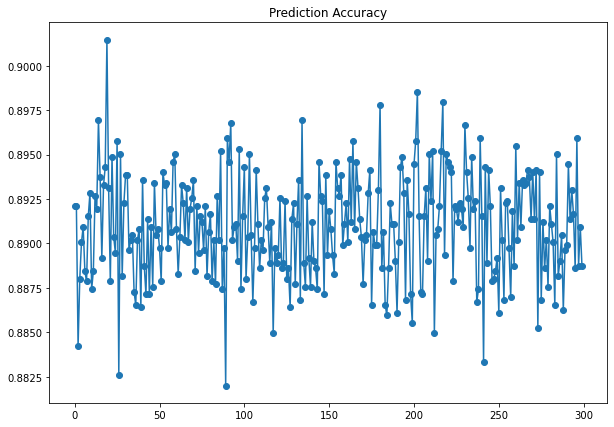

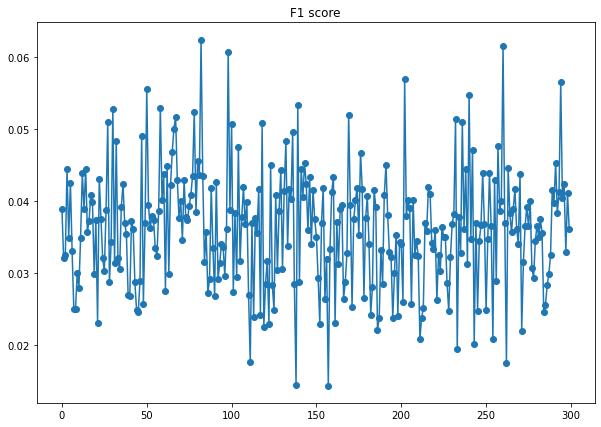

In [112]:
plt.figure(figsize=(10,7))
plt.plot(ni, accuracy, '-o')
plt.title("Prediction Accuracy")
plt.figure(figsize=(10,7))
plt.plot(ni, f1, '-o')
plt.title("F1 score")

Text(0.5, 1.0, 'F1 score')

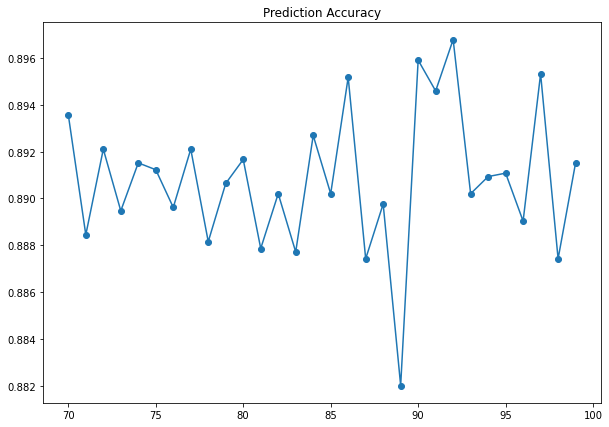

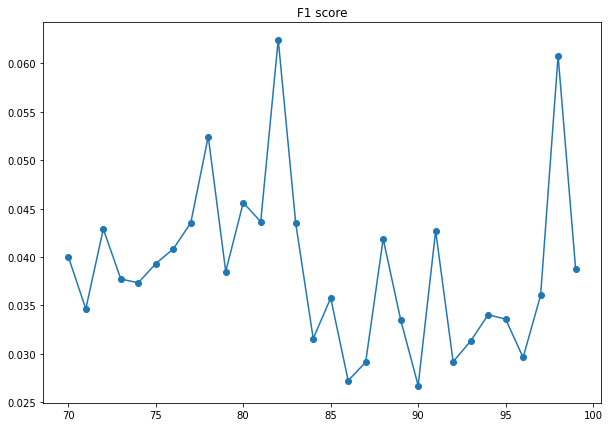

In [113]:
p = 70
q = 100
plt.figure(figsize=(10,7))
plt.plot(ni[p:q], accuracy[p:q], '-o')
plt.title("Prediction Accuracy")
plt.figure(figsize=(10,7))
plt.plot(ni[p:q], f1[p:q], '-o')
plt.title("F1 score")

In [101]:
np.argmax(accuracy)

138

In [114]:
np.argmax(f1)

82